# PK/PD AL Model Calibration
# Date: 06/16/2025

## Checking if the same ```pmax_artemether``` and ```ec50_lum``` give the same/simmilar efficacy across weights

<br>

In [1]:
import subprocess
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

<br>

# ```pmax_artemether``` = 0.9998653531
# and ```ec50_lum``` values for 4 genotypes

## AL maximum efficacy: 96.5%, 72.7892066535
## pfcrt K76: 92.5%, 121.5372211838
## pfcrt 76T: 91.9%, 129.4004601323
## pfmdr1 N86: 87.5%, 195.0108555496
## pfmdr1 86Y: 100%, 1.0000000000

<br>

<br>

## AL maximum efficacy: 96.5%, 
### ```pmax_artemether```: 0.9998653531
### ```ec50_lum```: 72.7892066535

In [ ]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        #"--pmax_artemether", "0.9998653531",
        "--pmax_artemether", "0.9999994",
        "--ec50_lum", "72.789",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [3]:
# Define the weight values to use
weight_values = [5, 10, 15, 20, 30, 40, 50, 60, 70]
#weight_values = [10]

# File suffix for saving results
file_suffix = "AL_max_efficacy"

for weight in weight_values:

        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg_{file_suffix}.csv", index=False)

        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-06-16 

Length of simulation:  0:00:25.350961 


The failed treatment count for weight 5kg is: 866

The percentage efficacy for weight 5kg is: 13.400000000000006 


Today's date:  2025-06-16 

Length of simulation:  0:00:24.356511 


The failed treatment count for weight 10kg is: 798

The percentage efficacy for weight 10kg is: 20.19999999999999 


Today's date:  2025-06-16 

Length of simulation:  0:00:25.331905 


The failed treatment count for weight 15kg is: 499

The percentage efficacy for weight 15kg is: 50.1 


Today's date:  2025-06-16 

Length of simulation:  0:00:25.194404 


The failed treatment count for weight 20kg is: 417

The percentage efficacy for weight 20kg is: 58.300000000000004 


Today's date:  2025-06-16 

Length of simulation:  0:00:25.392956 


The failed treatment count for weight 30kg is: 194

The percentage efficacy for weight 30kg is: 80.6 


Today's date:  2025-06-16 

Length of simulation:  0:00:24.009241 


The failed treatment count

In [4]:
# Load the dataframes
# Calculate the efficacy for each weight group

failed_treatment_count = []
efficacy = []
df_weight_compiled = []

for weight in [10, 20, 30, 40, 50]:
    # Load the dataframe
    df_weight = pd.read_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")
    # Calculate the efficacy
    failed_treatment_count.append(df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0])
    total_patients = df_weight['PID'].nunique()
    efficacy.append((1 - (failed_treatment_count[-1] / total_patients)) * 100 if total_patients > 0 else np.nan)
    # Append the dataframe to the list
    df_weight_compiled.append(df_weight)
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Weight': [10, 20, 30, 40, 50],
    'Failed Treatment Count': failed_treatment_count,
    'Efficacy': efficacy
})

# Save the results to a CSV file
results_df.to_csv(f"efficacy_results_compiled_{file_suffix}.csv", index=False)
# Save the results to a pickle file
results_df.to_pickle(f"efficacy_results_compiled_{file_suffix}.pyobj")
# Print the results
print("\nEfficacy Results:")
print(results_df)
 


Efficacy Results:
   Weight  Failed Treatment Count  Efficacy
0      10                     798      20.2
1      20                     417      58.3
2      30                     194      80.6
3      40                      86      91.4
4      50                      42      95.8


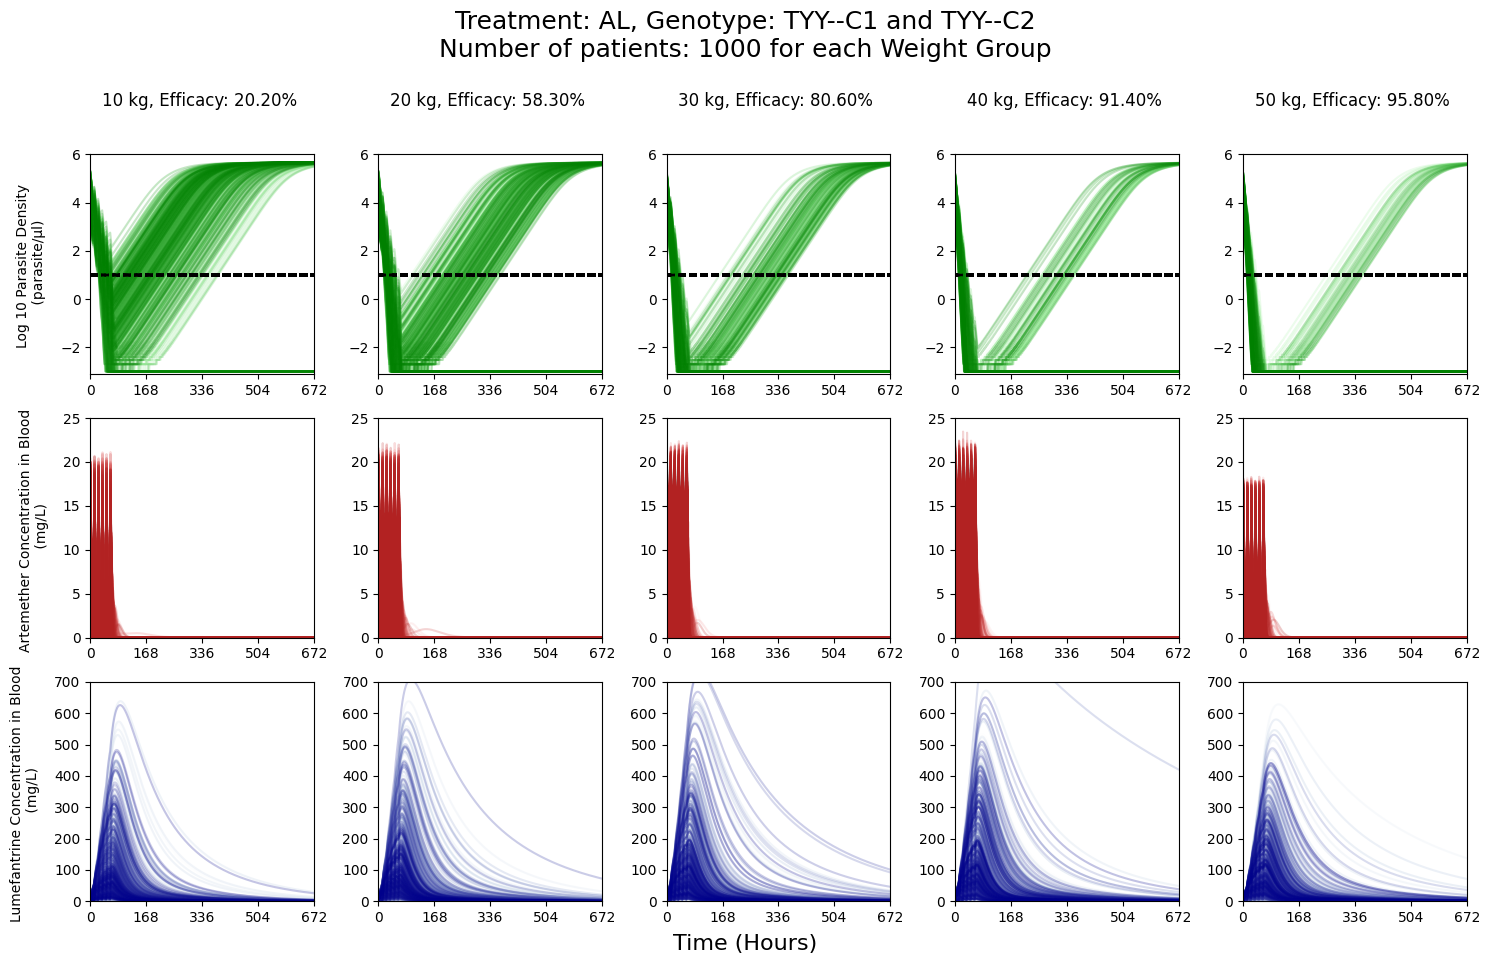

In [12]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 5:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3], 50: df_weight_compiled[4]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 5 weightgroups)
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40, 50]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3.1, 6)  # Set y-axis limits for Parasite Density
        ax[0, i].axhline(y=np.log10(10), color='black', linestyle='--') 

  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 700)
        ax[2, i].set_yticks(range(0, 800, 100))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 672)
        ax[j, i].set_xticks(range(0, 673, 168))

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(5):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL, Genotype: TYY--C1 and TYY--C2\nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig(f"df_weight_efficacy_{file_suffix}.png")
plt.show()


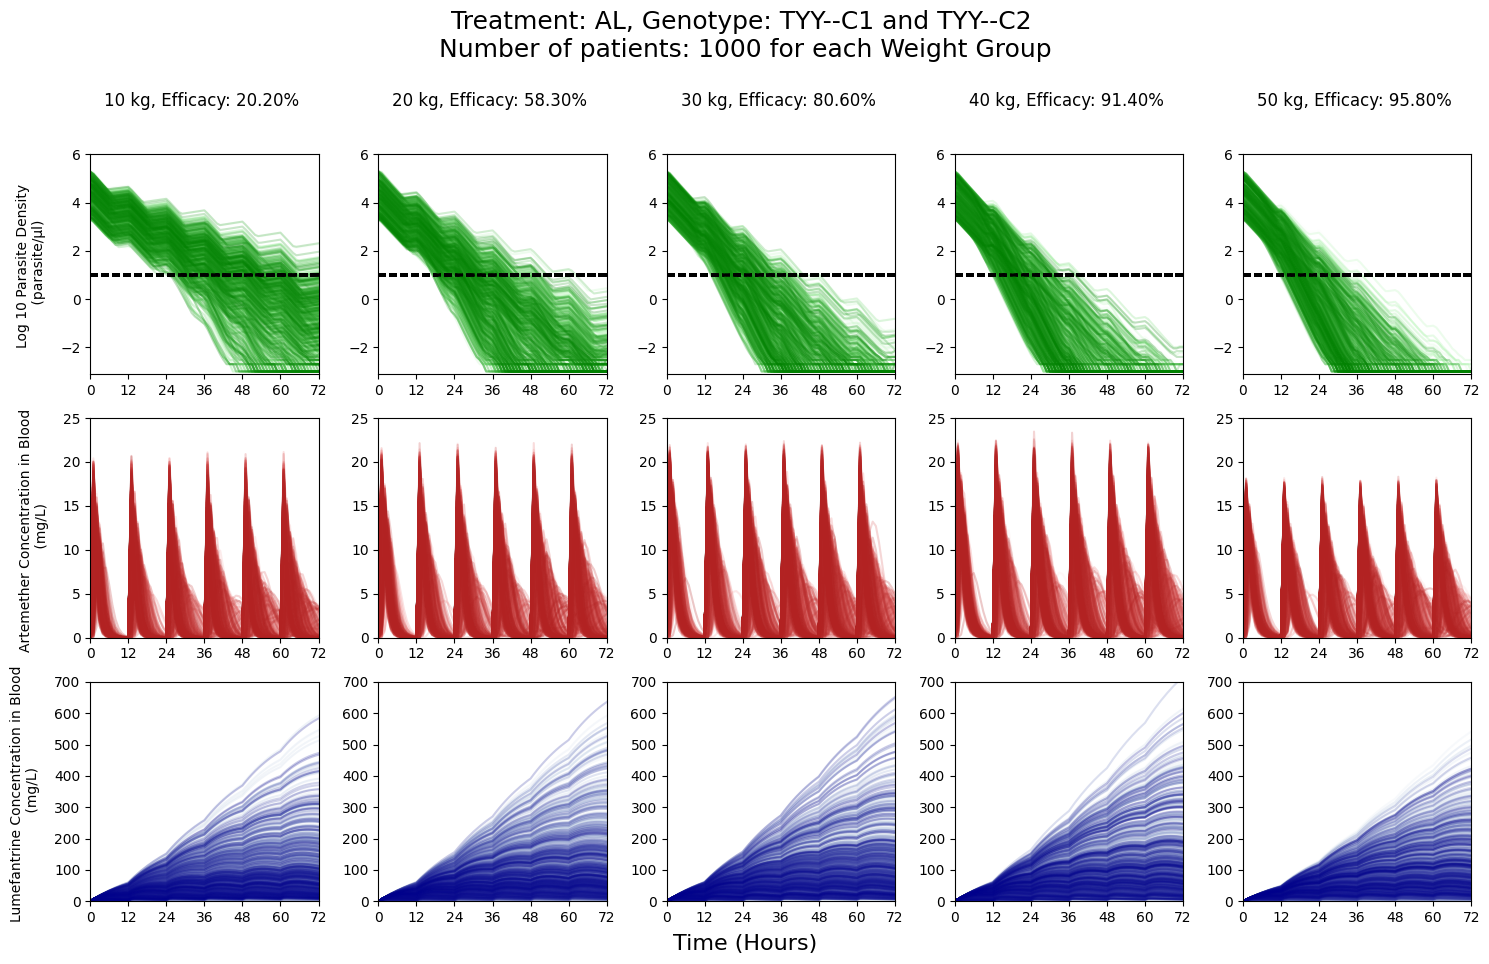

In [11]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 5:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3], 50: df_weight_compiled[4]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 5 weightgroups)
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40, 50]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3.1, 6)  # Set y-axis limits for Parasite Density
        ax[0, i].axhline(y=np.log10(10), color='black', linestyle='--') 

  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 700)
        ax[2, i].set_yticks(range(0, 800, 100))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 72)
        ax[j, i].set_xticks(range(0, 73, 12))

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(5):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL, Genotype: TYY--C1 and TYY--C2 \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig(f"df_weight_efficacy_{file_suffix}_72h.png")
plt.show()


<br>
<br>

<br>

## pfcrt K76: 92.5%
### ```pmax_artemether```: 0.9998653531
### ```ec50_lum```: 121.5372211838

In [10]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "5000",
        "--pmax_artemether", "0.9998653531",
        "--ec50_lum", "121.54",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [ ]:
# Define the weight values to use
weight_values = [15, 20, 30, 40, 50]
#weight_values = [10]

# File suffix for saving results
folder = "pfcrt_K76"
file_suffix = "pfcrt_K76"

for weight in weight_values:

        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg_{file_suffix}.csv", index=False)

        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")


In [13]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        #"--pmax_artemether", "0.9998653531",
        "--pmax_artemether", "0.9999994",
        "--ec50_lum", "72.789",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [14]:
# Define the weight values to use
weight_values = [10, 20, 30, 40, 50, 60, 70]
#weight_values = [10]

# File suffix for saving results
file_suffix = "AL_max_efficacy_02"

for weight in weight_values:

        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg_{file_suffix}.csv", index=False)

        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-06-16 

Length of simulation:  0:00:27.658156 


The failed treatment count for weight 10kg is: 444

The percentage efficacy for weight 10kg is: 55.6 


Today's date:  2025-06-16 

Length of simulation:  0:00:24.343979 


The failed treatment count for weight 20kg is: 34

The percentage efficacy for weight 20kg is: 96.6 


Today's date:  2025-06-16 

Length of simulation:  0:00:26.068924 


The failed treatment count for weight 30kg is: 1

The percentage efficacy for weight 30kg is: 99.9 


Today's date:  2025-06-16 

Length of simulation:  0:00:23.408044 


The failed treatment count for weight 40kg is: 0

The percentage efficacy for weight 40kg is: 100.0 


Today's date:  2025-06-16 

Length of simulation:  0:00:25.333082 


The failed treatment count for weight 50kg is: 0

The percentage efficacy for weight 50kg is: 100.0 


Today's date:  2025-06-16 

Length of simulation:  0:00:26.143833 


The failed treatment count for weight 60kg is: 0

The percentage effic

In [15]:
# Load the dataframes
# Calculate the efficacy for each weight group

failed_treatment_count = []
efficacy = []
df_weight_compiled = []

for weight in [10, 20, 30, 40, 50]:
    # Load the dataframe
    df_weight = pd.read_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")
    # Calculate the efficacy
    failed_treatment_count.append(df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0])
    total_patients = df_weight['PID'].nunique()
    efficacy.append((1 - (failed_treatment_count[-1] / total_patients)) * 100 if total_patients > 0 else np.nan)
    # Append the dataframe to the list
    df_weight_compiled.append(df_weight)
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Weight': [10, 20, 30, 40, 50],
    'Failed Treatment Count': failed_treatment_count,
    'Efficacy': efficacy
})

# Save the results to a CSV file
results_df.to_csv(f"efficacy_results_compiled_{file_suffix}.csv", index=False)
# Save the results to a pickle file
results_df.to_pickle(f"efficacy_results_compiled_{file_suffix}.pyobj")
# Print the results
print("\nEfficacy Results:")
print(results_df)
 


Efficacy Results:
   Weight  Failed Treatment Count  Efficacy
0      10                     444      55.6
1      20                      34      96.6
2      30                       1      99.9
3      40                       0     100.0
4      50                       0     100.0


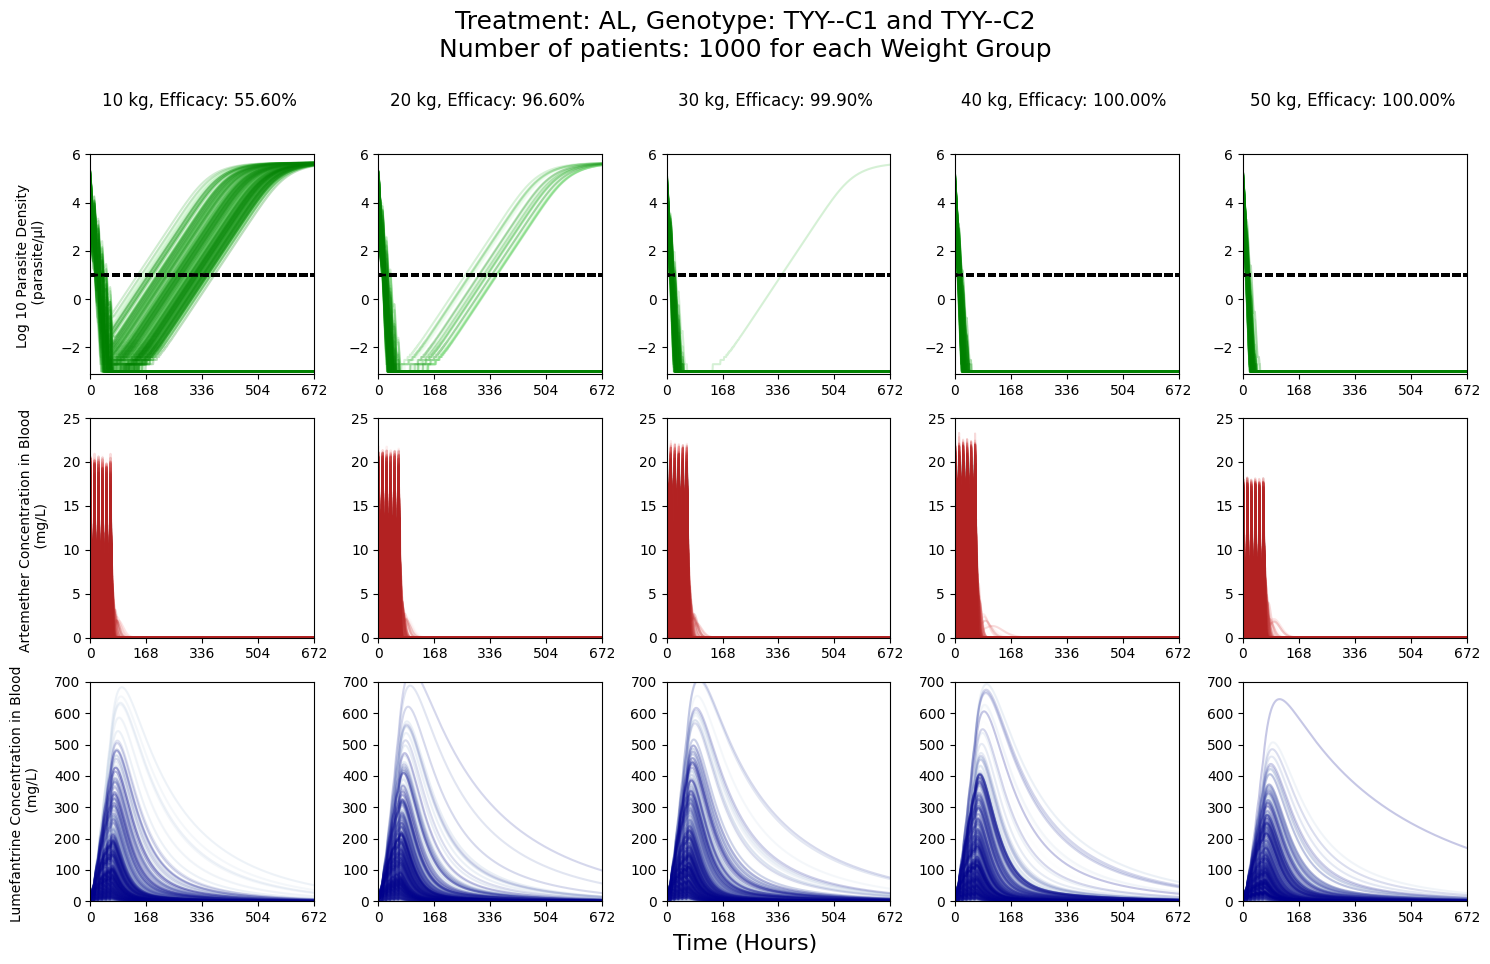

In [16]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 5:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3], 50: df_weight_compiled[4]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 5 weightgroups)
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40, 50]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3.1, 6)  # Set y-axis limits for Parasite Density
        ax[0, i].axhline(y=np.log10(10), color='black', linestyle='--') 

  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 700)
        ax[2, i].set_yticks(range(0, 800, 100))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 672)
        ax[j, i].set_xticks(range(0, 673, 168))

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(5):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL, Genotype: TYY--C1 and TYY--C2\nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig(f"df_weight_efficacy_{file_suffix}.png")
plt.show()


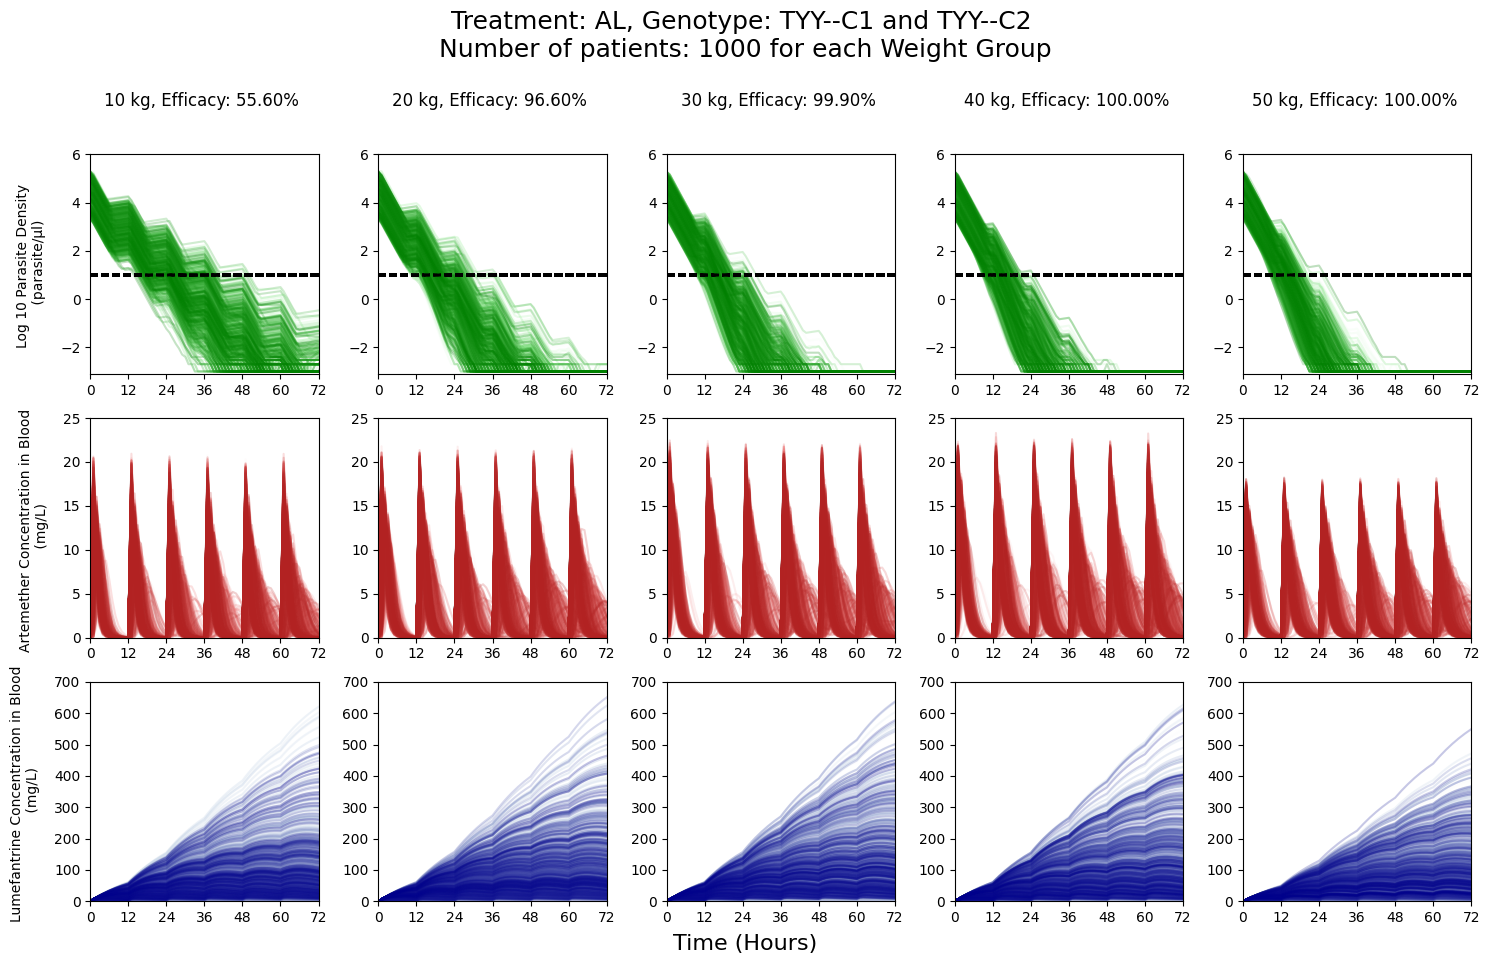

In [17]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 5:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3], 50: df_weight_compiled[4]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 5 weightgroups)
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40, 50]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3.1, 6)  # Set y-axis limits for Parasite Density
        ax[0, i].axhline(y=np.log10(10), color='black', linestyle='--') 

  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 700)
        ax[2, i].set_yticks(range(0, 800, 100))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 72)
        ax[j, i].set_xticks(range(0, 73, 12))

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(5):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL, Genotype: TYY--C1 and TYY--C2 \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig(f"df_weight_efficacy_{file_suffix}_72h.png")
plt.show()
